In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [4]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [5]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [6]:
# %%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

In [7]:
adata.X.max()

8.8678228953803

In [8]:
adata.layers["raw_count"] = np.exp(adata.X) - 1

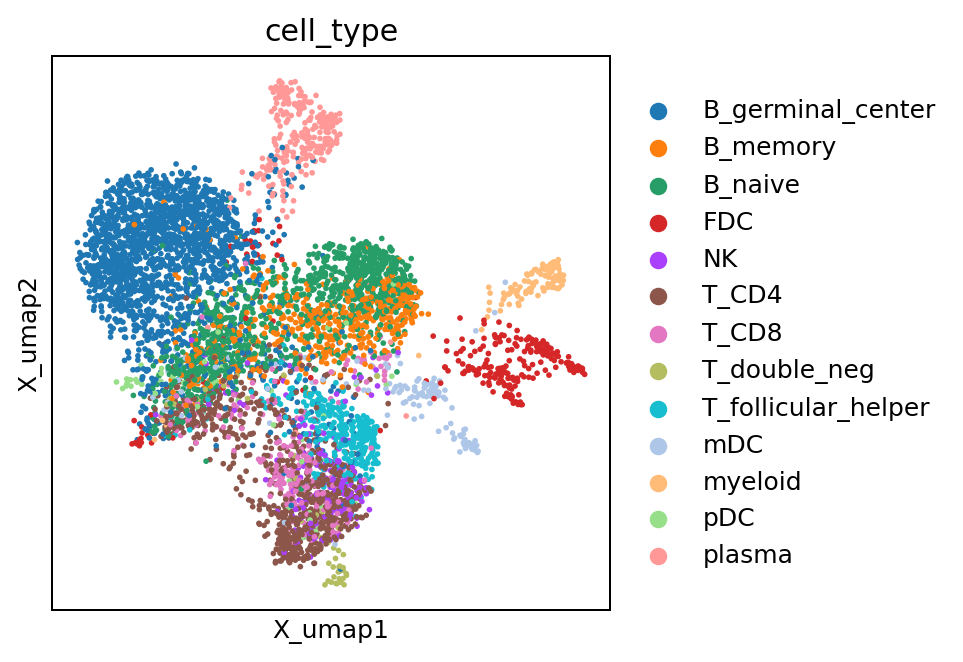

In [10]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [9]:
import decoupler as dc
net = dc.get_collectri(organism='human', split_complexes=False)

In [35]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
TF dict already exists. The old TF dict data was deleted. 



In [ ]:
# extra_grn = {
#     'FOXO1': np.unique(list(net[net.source == 'FOXO1'].target.values)),
# }

# oracle.addTFinfo_dictionary(co.utility.inverse_dictionary(extra_grn))

  0%|          | 0/279 [00:00<?, ?it/s]

In [37]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 13/13 [15:22<00:00, 70.96s/it]

CPU times: user 9min 21s, sys: 23.9 s, total: 9min 45s
Wall time: 15min 22s


In [39]:
links.links_dict['B_germinal_center'].query('source == "FOXO1" and target == "CXCR4"')

,source,target,coef_mean,coef_abs,p,-logp
18008,FOXO1,CXCR4,0.071202,0.071202,1.112498e-13,12.953701


In [40]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/13 [00:00<?, ?it/s]

In [41]:
import pickle

with open('/tmp/snrna_human_tonsil_colinks_enhanced.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)
    
    
links.to_hdf5(file_path="/tmp/links.celloracle.links")
oracle.to_hdf5("/tmp/tonsil.celloracle.oracle")

In [3]:
import sys
sys.path.append('/ix/djishnu/alw399/SpaceOracle/src')
import celloracle as co 

1 package does not meet CellOracle requirement.
 Your jupyter version is not_found. Please install jupyter


In [7]:
oracle = co.load_hdf5('/ix/djishnu/shared/djishnu_kor11/co_objects/tonsil.celloracle.oracle')
links = co.load_hdf5('/ix/djishnu/shared/djishnu_kor11/co_objects/tonsil.celloracle.links')

links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [8]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
targets = [
    'PAX5', 'BCL6',  'GATA3', 'STAT4', 'FOXO1', 'FOXP3', 
    # 'IL7', 'IL4',  'IL6ST', 'GZMA', 'IL10', 'LGALS9', 
    # 'PDCD1', 'CD27',  'CXCR4', 'CCR2', 'IL7R', 'CXCR4'
]

In [10]:
from tqdm import tqdm

In [11]:
for goi in tqdm(targets):
    
    oracle.simulate_shift(
        perturb_condition={goi: 0},
        n_propagation=4
    )

    oracle.adata.to_df(layer='simulated_count').to_csv(f'/ix/djishnu/shared/djishnu_kor11/co_results/celloracle_{goi}_KO.csv')

100%|██████████| 6/6 [06:08<00:00, 61.44s/it]


In [12]:
import glob

In [44]:
# oracle.adata.obs = oracle.adata.obs.join(pd.read_csv('../../notebooks/human_tonsil/tonsil_cell_types.csv', index_col=0))

In [45]:
ko_data = []
annot = 'cell_type_2'

for f in glob.glob('./CO_KO/*.csv'):
    data = pd.read_csv(f, index_col=0)
    data = data.loc[oracle.adata.obs_names] - oracle.adata.to_df(layer='imputed_count')
    data = data.join(oracle.adata.obs[annot]).groupby(annot).mean().abs().mean(axis=1)

    kotarget = f.split('/')[-1].split('_')[1]
    ds = {}
    for k, v in data.sort_values(ascending=False).to_dict().items():
        ds[k] = v

    data = pd.DataFrame.from_dict(ds, orient='index')
    data.columns = [kotarget]
    ko_data.append(data)
        
out = pd.concat(ko_data, axis=1)

In [49]:
oracle.adata.obs.cell_type_2.value_counts()

cell_type_2
B_naive                 1088
GC Light Zone            735
GC Dark Zone             558
B_memory                 522
GC Intermediate Zone     467
T_follicular_helper      300
FDC                      288
plasma                   283
T memory                 264
T_CD8                    244
Treg                     198
Naive CD4 T              177
NK                       170
mDC                      137
myeloid                  102
Th1                       88
pDC                       64
Th2                       47
T_double_neg              46
Name: count, dtype: int64

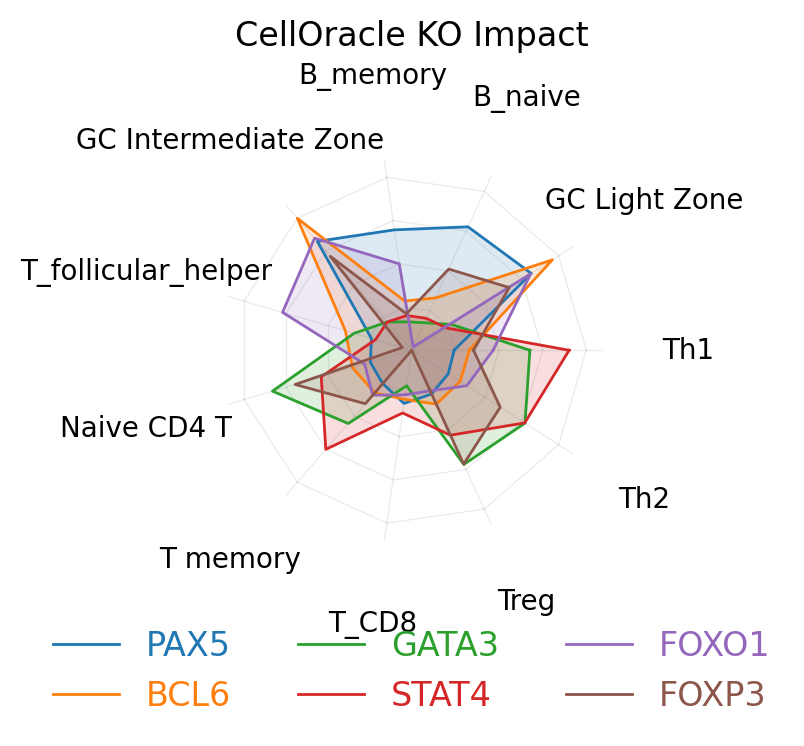

In [50]:
from sklearn.preprocessing import StandardScaler


genes=[['PAX5', 'BCL6',  'GATA3', 'STAT4', 'FOXO1', 'FOXP3']]
figsize=(10, 4)
dpi=200
rename = None

if isinstance(genes[0], str):
    genes = [genes]
    
splits = len(genes)
fig, axs = plt.subplots(1, splits, figsize=figsize, dpi=dpi,
    subplot_kw={'projection': 'polar'})

if splits == 1:
    axs = [axs]
else:
    axs = axs.flatten()

ko_concat =  out
show_for = ['Th1', 'GC Light Zone', 'B_naive', 'B_memory',
       'GC Intermediate Zone', 'T_follicular_helper', 'Naive CD4 T', 'T memory', 'T_CD8',
       'Treg', 'Th2', 
    ]

ko_concat = ko_concat.loc[show_for]

ko_concat_norm = pd.DataFrame(
    StandardScaler().fit_transform(ko_concat), 
    index=ko_concat.index, 
    columns=ko_concat.columns
)

# Scale values to 0-100% range
ko_concat_norm = (ko_concat_norm - ko_concat_norm.min().min()) / (ko_concat_norm.max().max() - ko_concat_norm.min().min()) * 100

for ax, geneset in zip(axs, genes):
    # Turn off default grid
    ax.grid(False)
    
    # Add percentage circles at 25% intervals
    circles = [0, 25, 50, 75, 100]
    ax.set_rticks(circles)
    
    # Remove all radial labels
    ax.set_yticklabels([])
    
    # Get the number of variables
    num_vars = len(ko_concat_norm.index)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    # Set the radial limits
    ax.set_rlim(0, 110)
    
    # Draw the spider web grid
    for circle in circles:
        if circle > 0:  # Skip the center point
            # Calculate points on the circle
            points = np.array([[circle * np.cos(angle), circle * np.sin(angle)] 
                                for angle in angles])
            
            # Connect the points to form the polygon
            for i in range(len(points)):
                j = (i + 1) % len(points)
                ax.plot([np.arctan2(points[i, 1], points[i, 0]), 
                        np.arctan2(points[j, 1], points[j, 0])],
                        [np.hypot(points[i, 0], points[i, 1]), 
                        np.hypot(points[j, 0], points[j, 1])],
                        color='gray', alpha=0.15, linewidth=0.5)
    
    # Draw lines from center to outer ring
    for angle in angles:
        ax.plot([angle, angle], [0, 110], 
                color='gray', alpha=0.15, linewidth=0.5)
    
    # Plot each gene's data
    for i, col in enumerate(geneset):
        # Get original or renamed label for the legend
        label = rename.get(col, col) if rename is not None else col
        
        values = ko_concat_norm[col].values.tolist()
        values += values[:1]  # Repeat first value to close polygon
        
        angles_plot = np.concatenate((angles, [angles[0]]))  # Complete the polygon

        ax.plot(angles_plot, values, '-', linewidth=1, label=label)
        ax.fill(angles_plot, values, alpha=0.15)

    # Customize axis labels with more spacing
    ax.set_xticks(angles)
    labels = ko_concat_norm.index
    ax.set_xticklabels(
        labels, size=10,
        rotation=0  # Keep labels horizontal
    )
    
    # Add more space for the labels
    ax.tick_params(pad=20)

    # Remove the outer circle
    ax.spines['polar'].set_visible(False)
    
    # Add legend with colored text
    legend = ax.legend(bbox_to_anchor=(0.5, -0.15), 
        loc='upper center', ncol=3, frameon=False, fontsize=12)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())

if splits > 1:
    for i in range(1, splits):
        fig.add_artist(plt.Line2D([i/splits, i/splits], [0.1, 0.9], 
                                transform=fig.transFigure, color='black', 
                                linestyle='--', linewidth=1, alpha=0.5))

plt.title('CellOracle KO Impact')
plt.tight_layout()

